In [50]:
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cars_data = pd.read_excel("data/Cars_Data_full.xlsx")

In [3]:
cars_data.head()

,Price,Age,KM,Fuel,HP,MC,Color,Auto,CC,Drs,...,AC,Comp,CD,Clock,Pwin,PStr,Radio,SpM,M_Rim,Tow_Bar
0,21000,26,31463,Petrol,195,0,Silver,0,1800,3,...,1,0,1,1,1,1,0,0,1,0
1,20000,23,43612,Petrol,195,0,Red,0,1800,3,...,1,1,0,1,1,1,0,1,1,0
2,19650,26,32191,Petrol,195,0,Red,0,1800,3,...,1,1,0,1,1,1,0,1,1,0
3,21550,32,23002,Petrol,195,1,Black,0,1800,3,...,1,1,1,1,1,1,0,1,1,0
4,22550,33,34133,Petrol,195,1,Grey,0,1800,3,...,1,1,1,1,1,1,0,1,1,0


In [4]:
cars_data.shape

(1367, 28)

<Axes: >

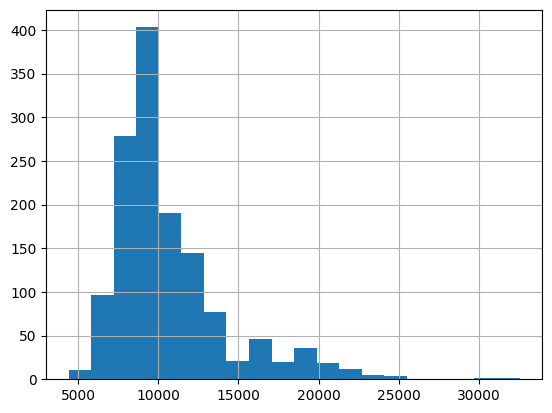

In [5]:
cars_data['Price'].hist(bins=20)

<Axes: xlabel='Price', ylabel='Density'>

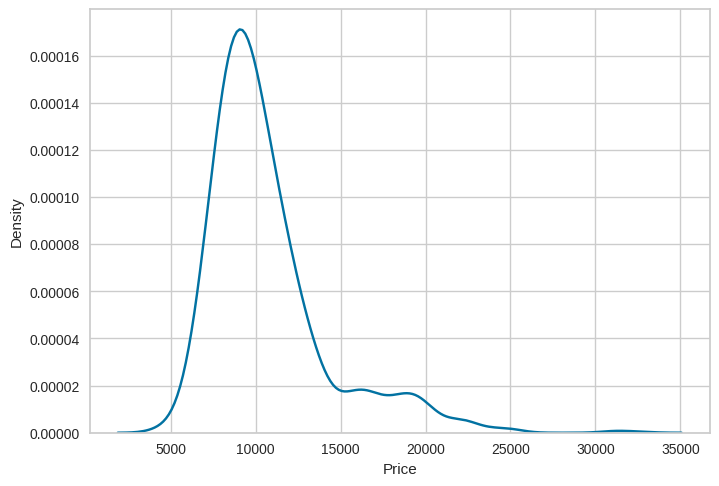

In [51]:
sns.kdeplot(y)

In [6]:
cars_data['Price'].describe()

count     1367.000000
mean     10682.416971
std       3555.986256
min       4400.000000
25%       8500.000000
50%       9945.000000
75%      11800.000000
max      32550.000000
Name: Price, dtype: float64

In [7]:
# anything at/above the 99th percentile should be dropped
cars_data['Price'].quantile(q=[0.0, 0.1, 0.05, 0.9, 0.95, 0.99])

0.00     4400.0
0.10     7500.0
0.05     6950.0
0.90    16000.0
0.95    18920.0
0.99    22300.0
Name: Price, dtype: float64

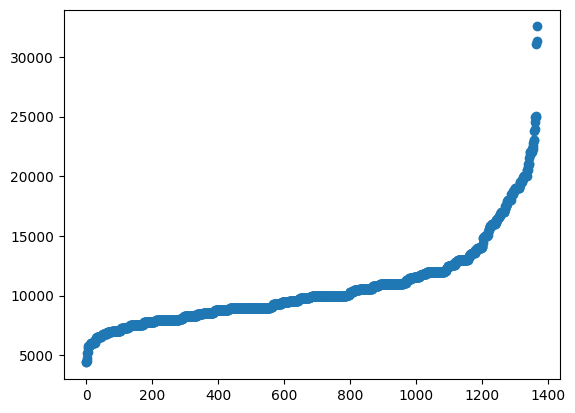

In [8]:
plt.scatter(cars_data.index, cars_data['Price'].sort_values())

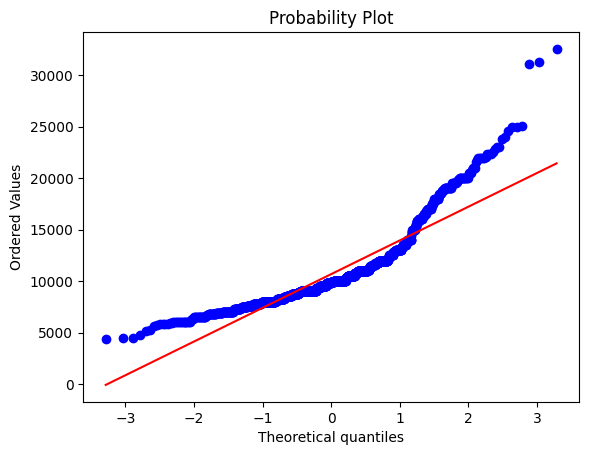

In [9]:
from scipy import stats

fig, ax = plt.subplots()

measurements = cars_data['Price'].sort_values()
stats.probplot(measurements, dist="norm", plot=ax)
plt.show()

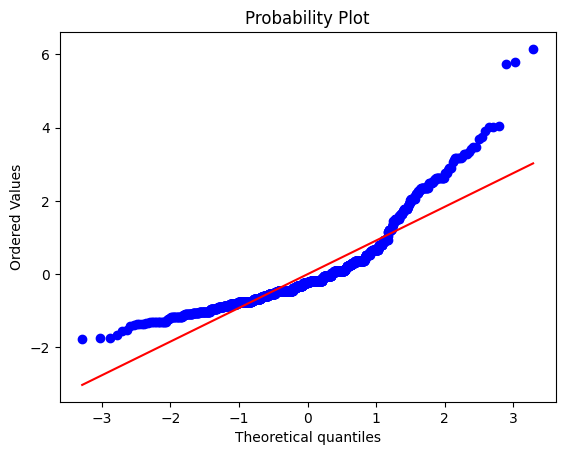

In [10]:
fig, ax = plt.subplots()

measurements = (cars_data['Price'] - cars_data['Price'].mean()) / cars_data['Price'].std()
stats.probplot(measurements, dist="norm", plot=ax)
plt.show()

In [11]:
measurements.describe()

count    1367.000000
mean        0.000000
std         1.000000
min        -1.766716
25%        -0.613730
50%        -0.207373
75%         0.314282
max         6.149513
Name: Price, dtype: float64

In [12]:
#cars_data = cars_data[(cars_data['Price'] > 5000.0) & (cars_data['Price'] < 20000.0)]
#cars_data.shape

In [13]:
#fig, ax = plt.subplots()
#stats.probplot(cars_data['Price'], dist="norm", plot=ax)
#plt.show()

In [14]:
numerical_features = cars_data.columns[cars_data.dtypes.apply(lambda x: x in ('int64', 'float64'))]
categorical_features = cars_data.columns[cars_data.dtypes.apply(lambda x: x == 'object')]

In [15]:
corr_mat = cars_data[numerical_features].corr(method='kendall')

Text(0, 0.5, 'Correlation')

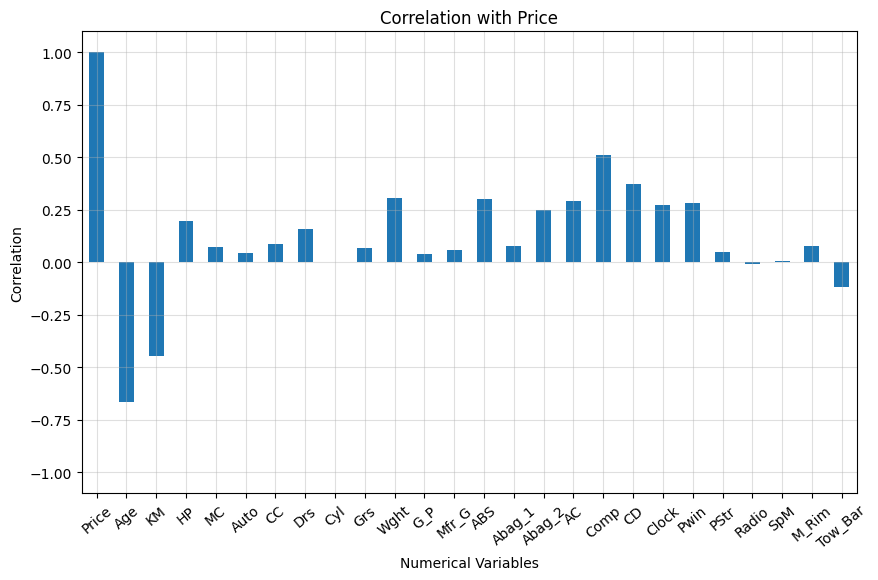

In [16]:
ax = corr_mat['Price'].plot(kind='bar', figsize=(10, 6))
ax.set_ylim(-1.1, 1.1)
ax.grid(alpha=0.4)
for item in ax.xaxis.get_ticklabels():
    item.set_rotation(40)

ax.set_title("Correlation with Price")
ax.set_xlabel("Numerical Variables")
ax.set_ylabel("Correlation")

In [17]:
corr_mat['Price'][corr_mat['Price'].abs() > 0.4]

Price    1.000000
Age     -0.666858
KM      -0.446466
Comp     0.513532
Name: Price, dtype: float64

In [18]:
cars_data['Fuel'].value_counts()

Fuel
Petrol    1225
Diesel     142
Name: count, dtype: int64

<Axes: title={'center': 'Price'}, xlabel='Fuel'>

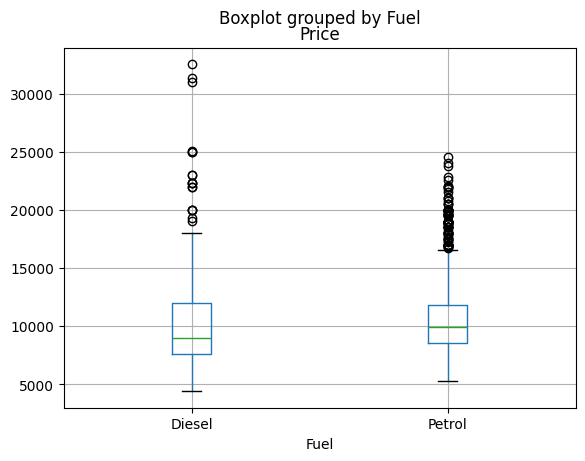

In [19]:
cars_data.boxplot(column='Price', by = 'Fuel')

In [20]:
cars_data['Color'].value_counts()

Color
Grey      290
Red       267
Blue      266
Green     215
Black     179
Silver    120
White      27
Yellow      3
Name: count, dtype: int64

<Axes: title={'center': 'Price'}, xlabel='Color'>

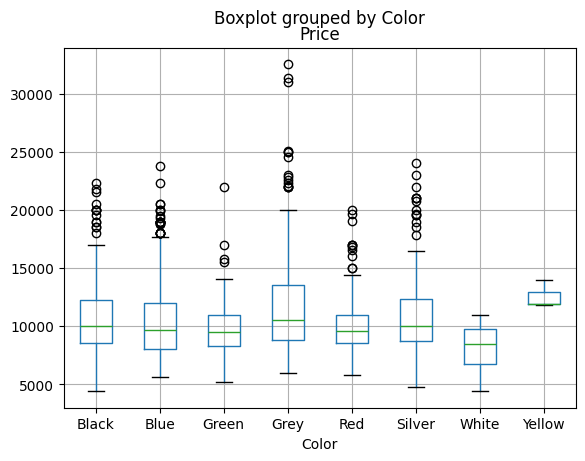

In [21]:
cars_data.boxplot(column='Price', by = 'Color')

In [22]:
if 'Price' in cars_data.columns:
    y = cars_data.pop('Price')

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2
#from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [24]:
numerical_features = cars_data.columns[cars_data.dtypes.apply(lambda x: x in ('int64', 'float64'))]
categorical_features = cars_data.columns[cars_data.dtypes.apply(lambda x: x == 'object')]

In [25]:
# transfomrer for numerical data
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)


# transformer for categorical data
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)


# combine pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ], verbose_feature_names_out=True
)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(cars_data, y, test_size=0.33, random_state=41232)

In [27]:
#numeric_transformer.fit_transform(X_train[numerical_features])

In [28]:
#categorical_transformer.fit_transform(X_train[categorical_features], y=y_train)

In [29]:
X_train = preprocessor.fit_transform(X_train, y_train)

In [30]:
X_test = preprocessor.transform(X_test)

In [31]:
param_grid = dict(loss = ['squared_error', 'absolute_error'],
                  learning_rate = [0.1, 0.2, 0.3],
                  max_iter = [100, 140, 200],
                  max_depth = [2, 3, 4],
                  max_leaf_nodes = [1, 2, 4, 10],
                  l2_regularization = [0.1, 0.2, 0.3],
                  validation_fraction = [0.2])

In [32]:
import datetime

In [33]:
start= datetime.datetime.now()

grid_search = GridSearchCV(
        estimator=HistGradientBoostingRegressor(),
        param_grid=param_grid,
        return_train_score=True,
        cv=5, 
        scoring='r2', 
        n_jobs=-1, 
        verbose=4
    ).fit(X_train, y_train)

end = datetime.datetime.now()

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV 1/5] END l2_regularization=0.1, learning_rate=0.1, loss=squared_error, max_depth=2, max_iter=100, max_leaf_nodes=1, validation_fraction=0.2;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END l2_regularization=0.1, learning_rate=0.1, loss=squared_error, max_depth=2, max_iter=100, max_leaf_nodes=1, validation_fraction=0.2;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END l2_regularization=0.1, learning_rate=0.1, loss=squared_error, max_depth=2, max_iter=100, max_leaf_nodes=1, validation_fraction=0.2;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END l2_regularization=0.1, learning_rate=0.1, loss=squared_error, max_depth=2, max_iter=100, max_leaf_nodes=1, validation_fraction=0.2;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END l2_regularization=0.1, learning_rate=0.1, loss=squared_error, max_depth=2, max_iter=100, max_leaf_nodes=4, validation_fraction=0.2;, score=(train=0.933

/home/jonathan/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
810 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jonathan/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jonathan/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/jonathan/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
   

In [34]:
print("Duration: {}".format(end-start), end, start)

Duration: 0:00:39.510706 2023-10-06 12:42:58.615555 2023-10-06 12:42:19.104849


In [35]:
est = grid_search.best_estimator_
print(est)
# HistGradientBoostingRegressor(l2_regularization=0.2, max_depth=4)

HistGradientBoostingRegressor(l2_regularization=0.3, max_depth=3, max_iter=200,
                              max_leaf_nodes=4, validation_fraction=0.2)


In [36]:
est.score(X_test, y_test)

0.9113966674301739

In [37]:
from yellowbrick.regressor import ResidualsPlot


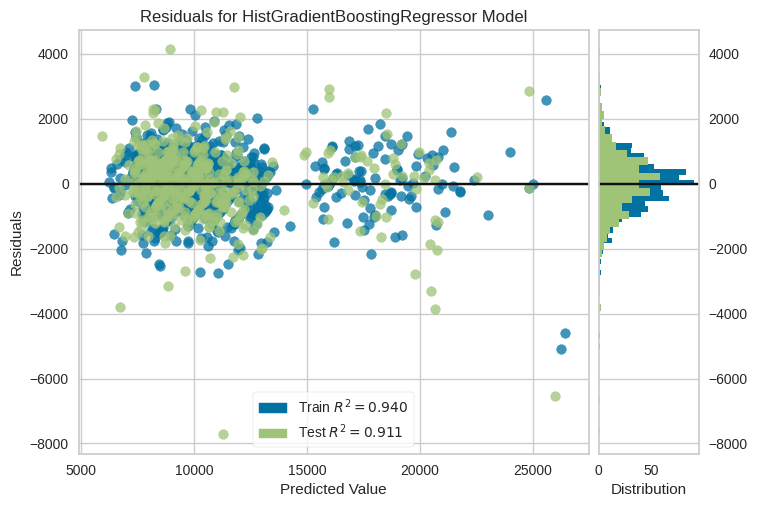

<Axes: title={'center': 'Residuals for HistGradientBoostingRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [45]:
#visualizer = ResidualsPlot(est)
visualizer = ResidualsPlot(estimator=est)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

In [39]:
y_test_pred = est.predict(X_test)
y_test_pred.shape

(452,)

In [40]:
pred_df = y_test.to_frame('y_test')
pred_df['y_pred'] = y_test_pred

In [41]:
pred_df.sample(20)

,y_test,y_pred
130,24550,20679.127115
854,8300,9592.847051
727,8800,8921.443933
963,12000,10672.355491
1029,6550,7106.179329
756,8000,8391.382909
374,9000,9533.334983
681,11000,10059.069268
91,16300,17132.939291
576,9000,8377.617414


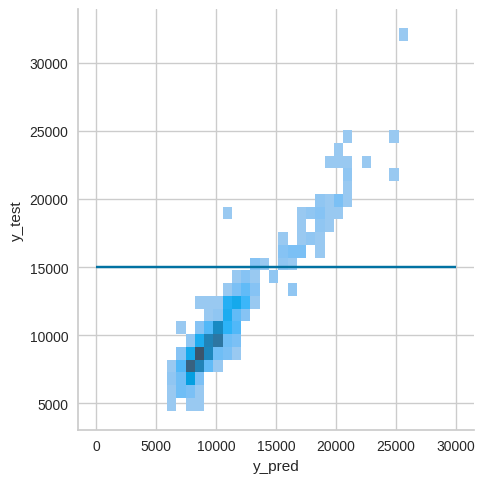

In [58]:
sns.displot(data=pred_df, x="y_pred", y="y_test")
plt.hlines(y = 15000, xmin=0, xmax=30000)

# Conclusions

The outliers seem to help because this data set appears to be bi-modal where there are essentially two clusters. One low priced below $15000, and the other high priced above $15000

In [47]:
idx = (y_test > 5000.0) & (y_test < 20000.0)
y_sub_test = y_test[idx]
X_sub_test = X_test[idx]

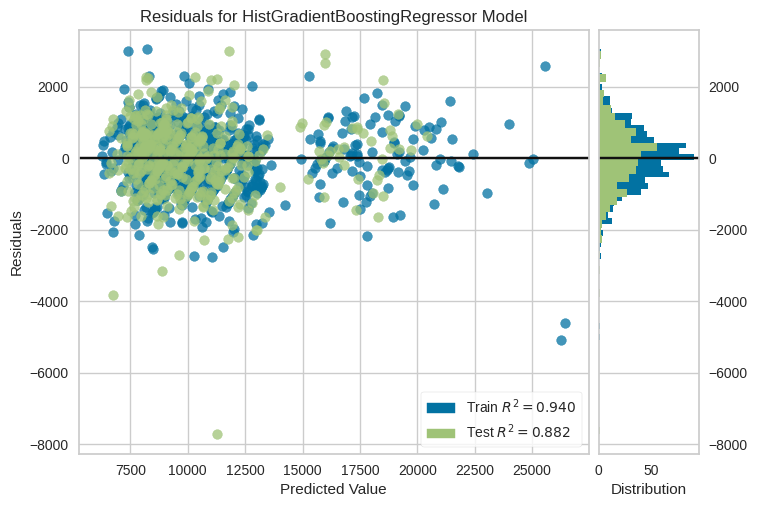

<Axes: title={'center': 'Residuals for HistGradientBoostingRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [48]:
#visualizer = ResidualsPlot(est)
visualizer = ResidualsPlot(estimator=est)
visualizer.fit(X_train, y_train)
visualizer.score(X_sub_test, y_sub_test)
visualizer.show()